## XGBoost Model for OSM Contributions Data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split


### Create directories required for the code

In [2]:
import os
import joblib

# Define the directory and file path for saving the model
save_dir = '../saved_parameters/contribution_model/'
model_file = os.path.join(save_dir, 'final_xgboost_model.pkl')

# Check if the directory exists, else create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Directory created at: {save_dir}")
else:
    print(f"Directory already exists at: {save_dir}")

Directory already exists at: ../saved_parameters/contribution_model/


### Load the data set into a data frame

In [3]:
features_df = pd.read_parquet("../data/contribution_data/extracted_features_v2.parquet")

#Shuffle the data entries
features_df = features_df.sample(frac=1, random_state=42).reset_index(drop=True)
features_df.head()

,user_id,user_edit_frequency,editor_used,area_delta,length_delta,area,length,bounding_box_size,geometry_valid,xmax,...,emergency,geological,healthcare,highway,historic,landuse,leisure,man_made,military,vandalism
0,1020680,1.329399,Level0 v1.2,1644,-216,1644,0,5.671549e-07,1,16.862373,...,0,0,0,0,0,1,0,0,0,False
1,1075986,0.495575,JOSM,117,0,117,0,3.177526e-08,1,5.159954,...,0,0,0,0,0,0,0,0,0,True
2,246941,61.000000,JOSM,0,0,0,0,0.000000e+00,1,1.646210,...,0,0,0,0,0,0,0,0,0,False
3,3392,8.180723,Potlatch 2,0,-205,0,210,3.094182e-07,1,-115.261025,...,0,0,0,1,0,0,0,0,0,True
4,1942179,2986.044444,,0,0,0,0,0.000000e+00,1,17.466017,...,0,0,0,0,0,0,0,0,0,True


### Drop unnecessary columns and replace spaces with underscores

In [4]:
if features_df.columns.__contains__('xzcode'):
    # Split 'xzcode' column into two separate columns 'code' and 'level'
    features_df[['code', 'level']] = pd.json_normalize(features_df['xzcode'])
    features_df.drop('xzcode', axis=1, inplace=True)

if features_df.columns.__contains__('geometry'):
    features_df.drop('geometry', axis=1, inplace=True)

if features_df.columns.__contains__('osm_id'):
    features_df.drop('osm_id', axis=1, inplace=True)

if features_df.columns.__contains__('members'):
    features_df.drop('members', axis=1, inplace=True)

if features_df.columns.__contains__('status'):
    features_df.drop('status', axis=1, inplace=True)

if features_df.columns.__contains__('editor_used'):
    features_df.drop('editor_used', axis=1, inplace=True)

features_df.columns = features_df.columns.str.replace(' ', '_', regex=True)

features_df.head()

,user_id,user_edit_frequency,area_delta,length_delta,area,length,bounding_box_size,geometry_valid,xmax,xmin,...,healthcare,highway,historic,landuse,leisure,man_made,military,vandalism,code,level
0,1020680,1.329399,1644,-216,1644,0,5.671549e-07,1,16.862373,16.861237,...,0,0,0,1,0,0,0,False,5016864557,16
1,1075986,0.495575,117,0,117,0,3.177526e-08,1,5.159954,5.159741,...,0,0,0,0,0,0,0,True,5014238182,16
2,246941,61.000000,0,0,0,0,0.000000e+00,1,1.646210,1.646210,...,0,0,0,0,0,0,0,False,5011061704,16
3,3392,8.180723,0,-205,0,210,3.094182e-07,1,-115.261025,-115.261189,...,0,1,0,0,0,0,0,True,3184713878,16
4,1942179,2986.044444,0,0,0,0,0.000000e+00,1,17.466017,17.466017,...,0,0,0,0,0,0,0,True,5020807494,16


### One-hot Encoding

In [5]:
X = features_df.drop('vandalism', axis=1).copy()
y = features_df['vandalism'].copy()
X_encoded = pd.get_dummies(X, columns=[
    'osm_type',
    'contribution_type',
])
assert X_encoded.dtypes.__contains__('object') == False
X_encoded.head()

,user_id,user_edit_frequency,area_delta,length_delta,area,length,bounding_box_size,geometry_valid,xmax,xmin,...,level,osm_type_node,osm_type_relation,osm_type_way,contribution_type_CREATED,contribution_type_DELETED,contribution_type_GEOMETRY,contribution_type_NONE,contribution_type_TAG,contribution_type_TAG_GEOMETRY
0,1020680,1.329399,1644,-216,1644,0,5.671549e-07,1,16.862373,16.861237,...,16,False,False,True,False,False,False,False,False,True
1,1075986,0.495575,117,0,117,0,3.177526e-08,1,5.159954,5.159741,...,16,False,False,True,True,False,False,False,False,False
2,246941,61.000000,0,0,0,0,0.000000e+00,1,1.646210,1.646210,...,16,True,False,False,False,False,False,False,True,False
3,3392,8.180723,0,-205,0,210,3.094182e-07,1,-115.261025,-115.261189,...,16,False,False,True,False,False,True,False,False,False
4,1942179,2986.044444,0,0,0,0,0.000000e+00,1,17.466017,17.466017,...,16,True,False,False,True,False,False,False,False,False


### Format y and check ratio of x:y

In [6]:
y = y.replace(True, 1)
y = y.replace(False, 0)
sum(y) / len(y)

C:\Users\saise\AppData\Local\Temp\ipykernel_19104\1318066108.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace(False, 0)


0.6621638875411762

### Split the data between train and test set & print statistics

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.4, random_state=42, stratify=y)

# Get the shapes of the datasets
shapes = {
    'X_train shape': X_train.shape,
    'X_test shape': X_test.shape,
    'y_train shape': y_train.shape,
    'y_test shape': y_test.shape
}

# Convert shapes to DataFrame for better display
shapes_df = pd.DataFrame(shapes, index=['Number of Samples', 'Number of Features']).T
print(shapes_df)
print()

# 1. Calculate the total number of samples in train and test sets
total_train = len(y_train)
total_test = len(y_test)

# 2. Calculate the number of vandalism (assuming 'vandalism' is labeled as 1)
vandalism_train = sum(y_train)
vandalism_test = sum(y_test)

# 3. Calculate the number of non-vandalism (assuming 'non-vandalism' is labeled as 0)
non_vandalism_train = total_train - vandalism_train
non_vandalism_test = total_test - vandalism_test

# 4. Print the statistics
print(f"Train Set Statistics:\n"
      f"Total: {total_train}\n"
      f"Vandalism: {vandalism_train}\n"
      f"Non-Vandalism: {non_vandalism_train}\n")

print(f"Test Set Statistics:\n"
      f"Total: {total_test}\n"
      f"Vandalism: {vandalism_test}\n"
      f"Non-Vandalism: {non_vandalism_test}\n")

print("sum(y_train)/len(y_train): " + str(sum(y_train) / len(y_train)))
print("sum(y_test)/len(y_test): " + str(sum(y_test) / len(y_test)))


               Number of Samples  Number of Features
X_train shape             281959                  59
X_test shape              187973                  59
y_train shape             281959              281959
y_test shape              187973              187973

Train Set Statistics:
Total: 281959
Vandalism: 186703
Non-Vandalism: 95256

Test Set Statistics:
Total: 187973
Vandalism: 124469
Non-Vandalism: 63504

sum(y_train)/len(y_train): 0.6621636479062559
sum(y_test)/len(y_test): 0.6621642469929192


### Model training with random hyperparameters and without cross validation

In [8]:
from model.xgboost_training import train_final_model, save_model
from model.hyper_parameter_search import get_random_parameters

random_parameters = get_random_parameters()

# Train Final Model with random parameters
final_base_model = train_final_model(X_train, y_train, X_test, y_test, random_parameters)

# Save the Model
save_model(final_base_model, '../saved_parameters/contribution_model/final_xgboost_base_model.pkl')


2024-10-30 01:36:01 - INFO - hyper_parameter_search.py -- Random Hyperparameters Generated: {'learning_rate': 0.01, 'max_depth': 7, 'subsample': 0.8, 'colsample_bytree': 0.6, 'lambda': 10, 'alpha': 0, 'min_child_weight': 10, 'gamma': 3, 'n_estimators': 100}

2024-10-30 01:36:11 - INFO - xgboost_training.py -- Model training complete.

2024-10-30 01:36:11 - INFO - xgboost_training.py -- Model saved to ../saved_parameters/contribution_model/final_xgboost_base_model.pkl


### Base model evaluation

Evaluating model performance on both training and test datasets...

Train Set Evaluation
Accuracy: 0.9101465106628978
AUC-ROC: 0.9804100784479052
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.95      0.77      0.85     95256
           1       0.89      0.98      0.94    186703

    accuracy                           0.91    281959
   macro avg       0.92      0.88      0.89    281959
weighted avg       0.91      0.91      0.91    281959


Test Set Evaluation
Accuracy: 0.9082474610715369
AUC-ROC: 0.9799343348766776
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.95      0.77      0.85     63504
           1       0.89      0.98      0.93    124469

    accuracy                           0.91    187973
   macro avg       0.92      0.87      0.89    187973
weighted avg       0.91      0.91      0.91    187973


AUC-PR Score on Test Set: 0.9901791977508855
ROC-AUC Score

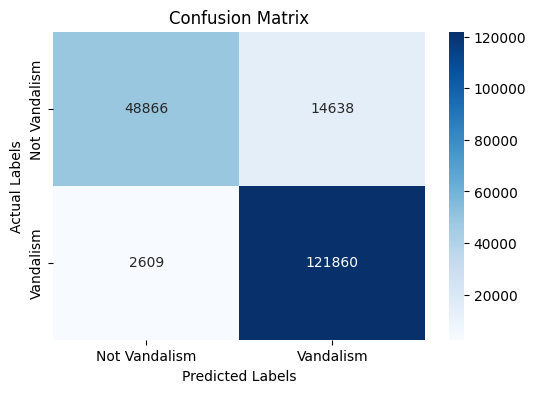

In [9]:
from evaluate_xgboost_model import (evaluate_train_test_metrics, calculate_auc_scores,
                                    plot_confusion_matrix)

# Evaluate Train and Test Metrics
y_test_pred, y_test_prob = evaluate_train_test_metrics(final_base_model, X_train, y_train, X_test, y_test)

# Calculate AUC Scores and Get Confusion Matrix
cm = calculate_auc_scores(y_test, y_test_pred, y_test_prob)

# Plot Confusion Matrix
plot_confusion_matrix(cm)

### Hyperparameter tuning with cross validation and model training with best parameters

In [10]:
from model.hyper_parameter_search import randomized_search_cv
from model.xgboost_training import train_final_model, save_model
from model.evaluate_xgboost_model import evaluate_model_with_cv

# Search and Load Hyperparameters
best_params = randomized_search_cv(X_train, y_train, '../saved_parameters/contribution_model/best_hyperparameters.json')

# Train Final Model with best_params
final_tuned_model = train_final_model(X_train, y_train, X_test, y_test, best_params)

# (OPTIONAL): Perform Final Cross-Validation on Full Dataset
cv_scores = evaluate_model_with_cv(X_train, y_train, best_params)

# Save the Model
save_model(final_tuned_model, '../saved_parameters/contribution_model/final_xgboost_model_tuned.pkl')



2024-10-30 01:36:13 - INFO - hyper_parameter_search.py -- Hyperparameters file already exists.

2024-10-30 01:36:13 - INFO - load_hyper_parameters.py -- Loaded hyperparameters from ../saved_parameters/contribution_model/best_hyperparameters.json

2024-10-30 01:36:13 - INFO - hyper_parameter_search.py -- best hyper parameters: {'subsample': 0.9, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.3, 'lambda': 0, 'gamma': 2, 'colsample_bytree': 0.7, 'alpha': 0}

2024-10-30 01:36:23 - INFO - xgboost_training.py -- Model training complete.



Performing 5-fold Cross-Validation on the entire data...



2024-10-30 01:36:32 - INFO - xgboost_training.py -- Model saved to ../saved_parameters/contribution_model/final_xgboost_model_tuned.pkl


Cross-Validation AUC Scores: [0.99963166 0.99970849 0.99968457 0.99974075 0.99966955]
Mean AUC Score: 0.9996870023751103
Standard Deviation of AUC Scores: 3.66727106901221e-05


### Tuned model evaluation

Evaluating model performance on both training and test datasets...

Train Set Evaluation
Accuracy: 0.9977053401381052
AUC-ROC: 0.9999475200736144
Classification Report (Train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     95256
           1       1.00      1.00      1.00    186703

    accuracy                           1.00    281959
   macro avg       1.00      1.00      1.00    281959
weighted avg       1.00      1.00      1.00    281959


Test Set Evaluation
Accuracy: 0.9952280380692972
AUC-ROC: 0.9997874191409399
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     63504
           1       1.00      1.00      1.00    124469

    accuracy                           1.00    187973
   macro avg       0.99      1.00      0.99    187973
weighted avg       1.00      1.00      1.00    187973

AUC-PR Score on Test Set: 0.999897361318275
ROC-AUC Score o

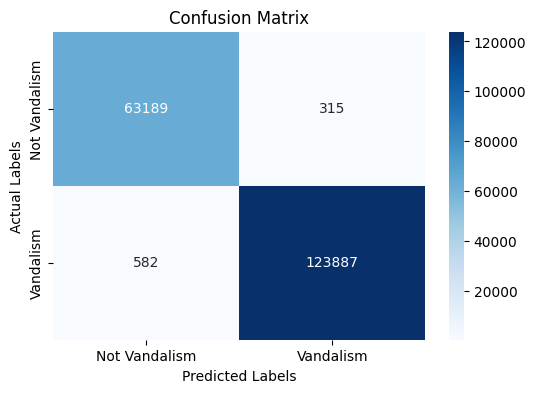

In [11]:
from evaluate_xgboost_model import (evaluate_train_test_metrics, calculate_auc_scores,
                                    plot_confusion_matrix)

# Evaluate Train and Test Metrics
y_test_pred, y_test_prob = evaluate_train_test_metrics(final_tuned_model, X_train, y_train, X_test, y_test)

# Calculate AUC Scores and Get Confusion Matrix
cm = calculate_auc_scores(y_test, y_test_pred, y_test_prob)

# Plot Confusion Matrix
plot_confusion_matrix(cm)